# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

## Calibrating and synthetic simulation of multi-site Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Space-Time Neyman Scott Rectangular Pulse Model) using several rainfall series from a basin located in northern Spain. The calibration parameters are used to simulate several decades of multi-site synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>**Please, be advised that some of the processes may take up to 20 minutes in a modern computer.**</font>

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import psutil

In [3]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.STNSRP.Simulation import Simulation
from NEOPRENE.STNSRP.Analysis import Analysis

In [4]:
import warnings
warnings.filterwarnings('ignore')

## Example 1. Calibration and validation of daily data

### Loading daily rainfall for Asón river basin

<font color='red'>__To calculate the cross-correlation statistic all the gauges have to overlap in any time. However, it is not necesary that all the series cover the entire period.__</font>

In [5]:
Series_SPD = pd.read_csv('auxiliary-materials/SPD/Rainfall_Series.csv', index_col=0, parse_dates=True)
Series_SPD[Series_SPD.values<0]=np.nan
Input_Series=Series_SPD.copy()

### Loading attributes for the series

In [6]:
Attributes_SPD= pd.read_csv('auxiliary-materials/SPD/Attributes.csv')
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_SPD.Id
Input_Attr['X']=Attributes_SPD.Longitud.values
Input_Attr['Y']=Attributes_SPD.Latitud.values
Input_Attr['Elevation']=Attributes_SPD.Height.values

### Shorting ID series to match with Input_Attr

In [7]:
Input_Series = Input_Series[Input_Attr.ID]

### Plotting rainfall series, seasonality

Text(0, 0.5, 'mm/month')

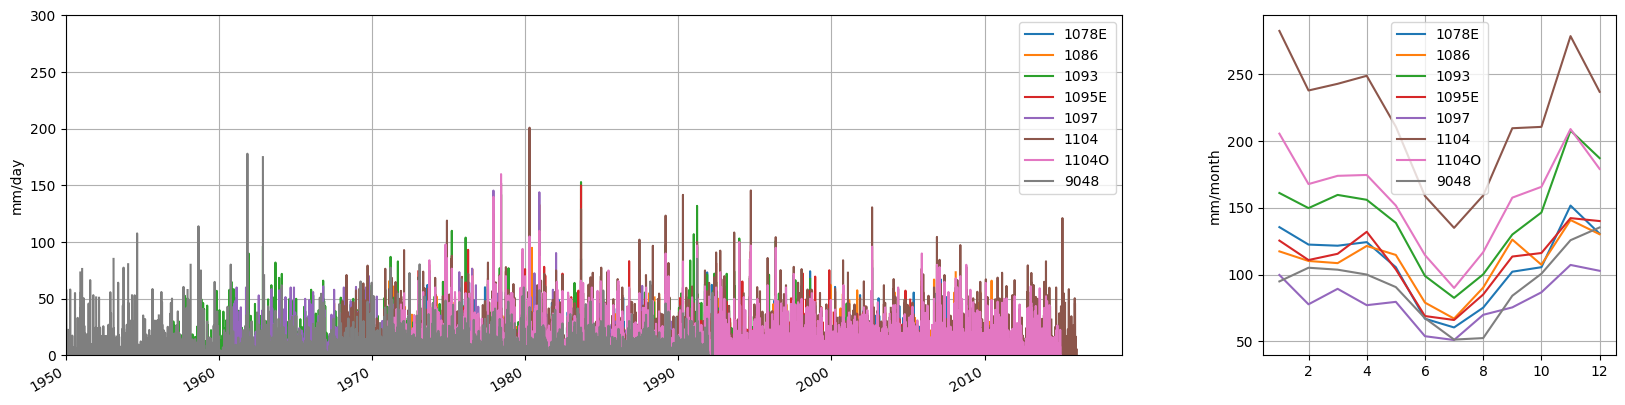

In [8]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Plotting gauge position

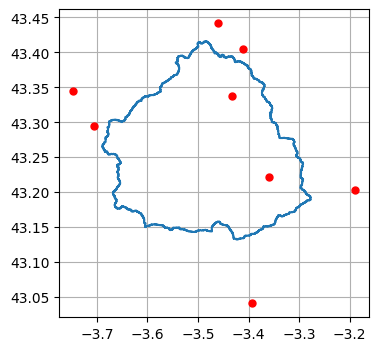

In [9]:
sf = shp.Reader("auxiliary-materials/SPD/Subbasin_WGS84.shp")

fig, ax = plt.subplots(figsize=(4, 4))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y)
ax.plot(Input_Attr.X, Input_Attr.Y, '.r',markersize=10)
ax.grid()

### Calibration

The calibration input file ([Input_Cal_SPD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_SPD.yml)) contains the hyperparameters to calibrate the space-time model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.STNSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_SPD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_SPD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [10]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SPD.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [11]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
statistics_model_2 = Statistics(hiper_params_cal, files_folder = './statistics_SPD/')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [12]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=False)
os.makedirs('./POINT_SPATIAL_DAILY/CAL1/',exist_ok=True)
CAL1.save_files('./POINT_SPATIAL_DAILY/CAL1/') #save python objects

2024-07-03 13:34:01,340 - INFO - 

################################################################################
2024-07-03 13:34:01,341 - INFO - Adjustment of parameters using the Particle Swarm Optimization (PSO)




### Simulation

The input simulation file ([Input_Sim_SPD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_SPD.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_SPD.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_SPD.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [13]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SPD.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [14]:
SIM              = Simulation(hiper_params_sim) 

# Input parameters from the model
# SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

# Input parameters from a dataframe
SIM1             = SIM(params_cal =['./POINT_SPATIAL_DAILY/CAL1/Calibrated_parameters.csv',
                                    './POINT_SPATIAL_DAILY/CAL1/xi_months.csv'], Input_Attr = Input_Attr)

os.makedirs('./POINT_SPATIAL_DAILY/SIM1/',exist_ok=True)
SIM1.save_files('./POINT_SPATIAL_DAILY/SIM1/')



################################################################################
Synthetic simulation


Simulation corners: 
 xp:[-4.451296154671874, -2.484503845328126, -2.484503845328126, -4.451296154671874]
 yp:[42.33620384532813, 42.33620384532813, 44.14659615467187, 44.14659615467187]
Simulation area (km²):32543.028731657025
Cells per storm per km²: 
[0.00320256 0.00320256 0.00320256 0.00235456 0.00235456 0.00235456
 0.00226672 0.00226672 0.00226672 0.00388359 0.00388359 0.00388359]
Cells per storm in my simulation area: 
[104.22089627 104.22089627 104.22089627  76.62451068  76.62451068
  76.62451068  73.76593715  73.76593715  73.76593715 126.38364145
 126.38364145 126.38364145]
Number of storms 1635 for the months (1, 2, 3)
Number of rain cells per storm 105.6256880733945


100%|██████████| 1635/1635 [00:34<00:00, 46.74it/s]


Number of storms 1757 for the months (4, 5, 6)
Number of rain cells per storm 77.30904951622082


100%|██████████| 1757/1757 [00:27<00:00, 64.57it/s]


Number of storms 1268 for the months (7, 8, 9)
Number of rain cells per storm 74.9589905362776


100%|██████████| 1268/1268 [00:18<00:00, 69.05it/s]


Number of storms 1288 for the months (10, 11, 12)
Number of rain cells per storm 127.20652173913044


100%|██████████| 1288/1288 [00:51<00:00, 24.96it/s]


<font color='red'>__Note that the STNSRPM reproduces the mean statistics of the basin computed from all the series (Input_series). Only the statistic rainfall mean is adjusted independetly per every single gauge.__</font>

## Analysis of results
In this section, an analysis of the results is made. 

In [15]:
Analysis_results = Analysis(CAL1,SIM1,hiper_params_sim)

### Verification

We verificate first that the rainfall mean is properly reproduced in every single station.

Text(0, 0.5, 'Daily rainfall mean (simulated)')

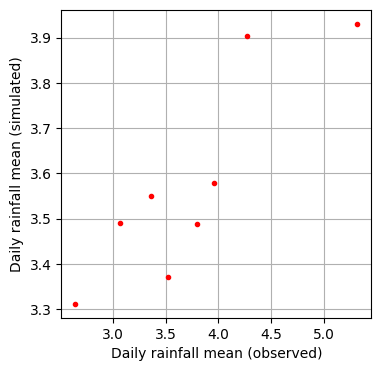

In [16]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(Input_Series.mean(axis=0), SIM1.Daily_Simulation.mean(axis=0), '.r')
ax.grid()
ax.set_xlabel('Daily rainfall mean (observed)')
ax.set_ylabel('Daily rainfall mean (simulated)')

The curve of exceedence probabilities is shown to evaluate the quality of the fit of the simulations and the observations

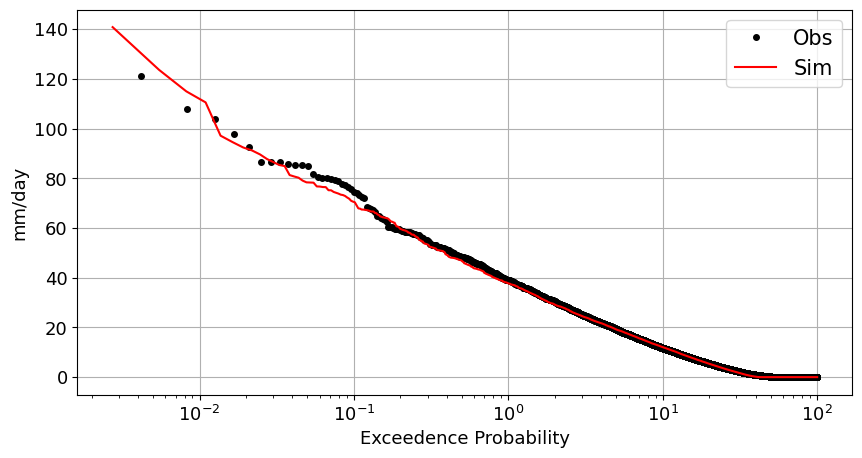

In [17]:
# Comparing exceedence Probability betwen Observed and Simulated series
Analysis_results.exceedence_probability_fig(Input_Series,SIM1.Daily_Simulation)

We verificate that the cross-correlation is properly reproduced (the figure show the cross-correlation for every temporal aggregation and period of the year).

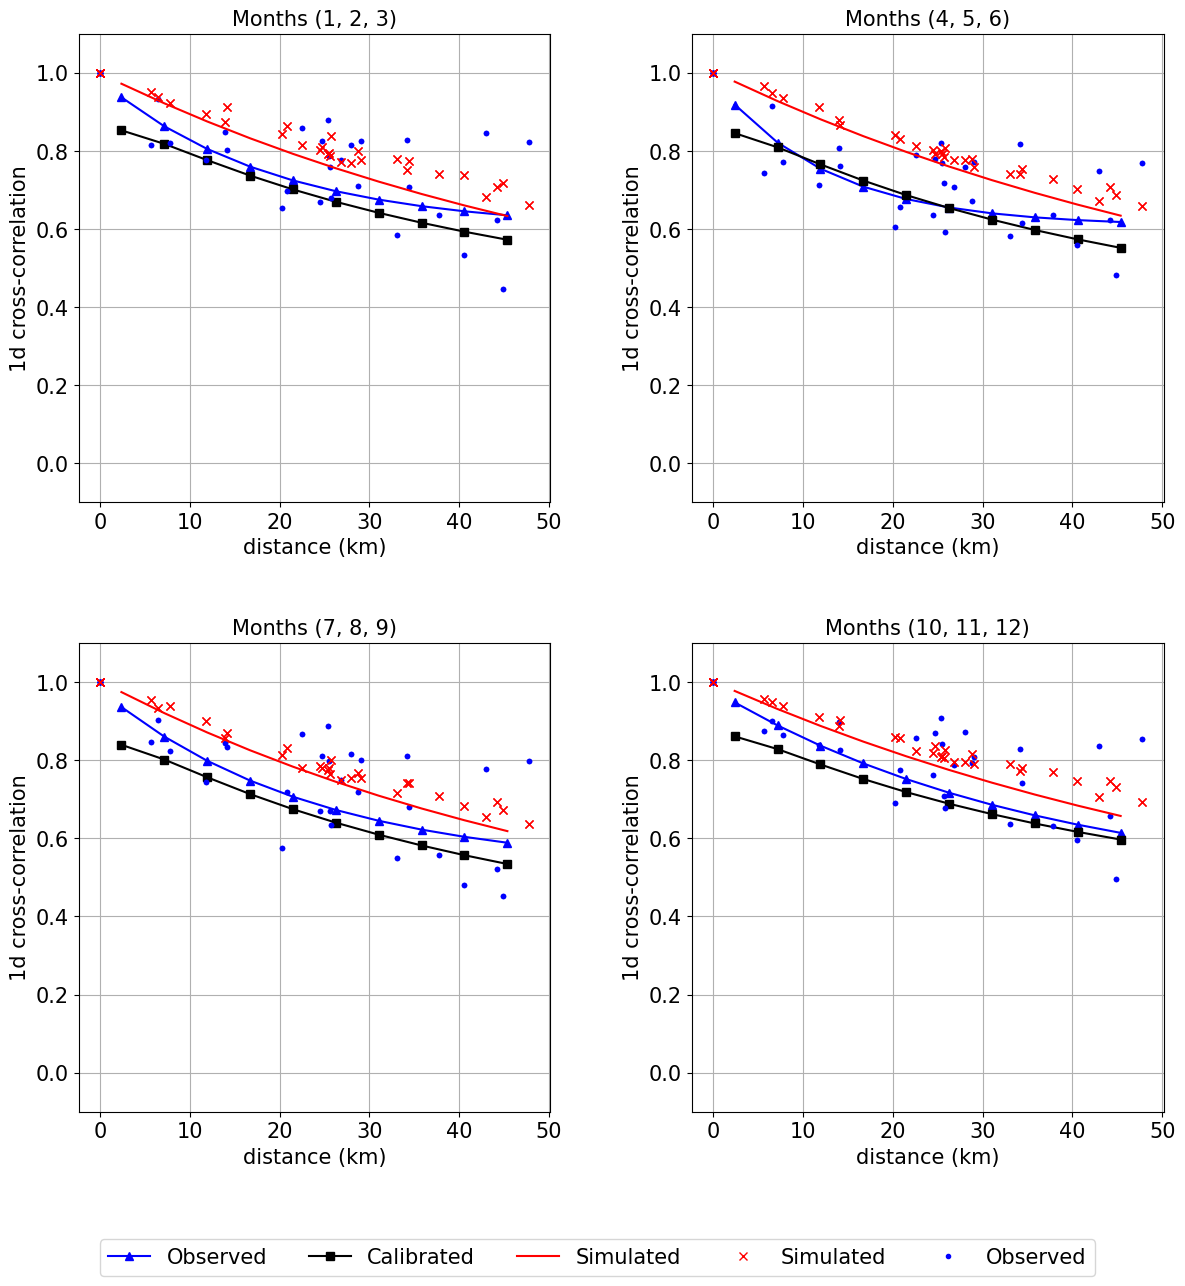

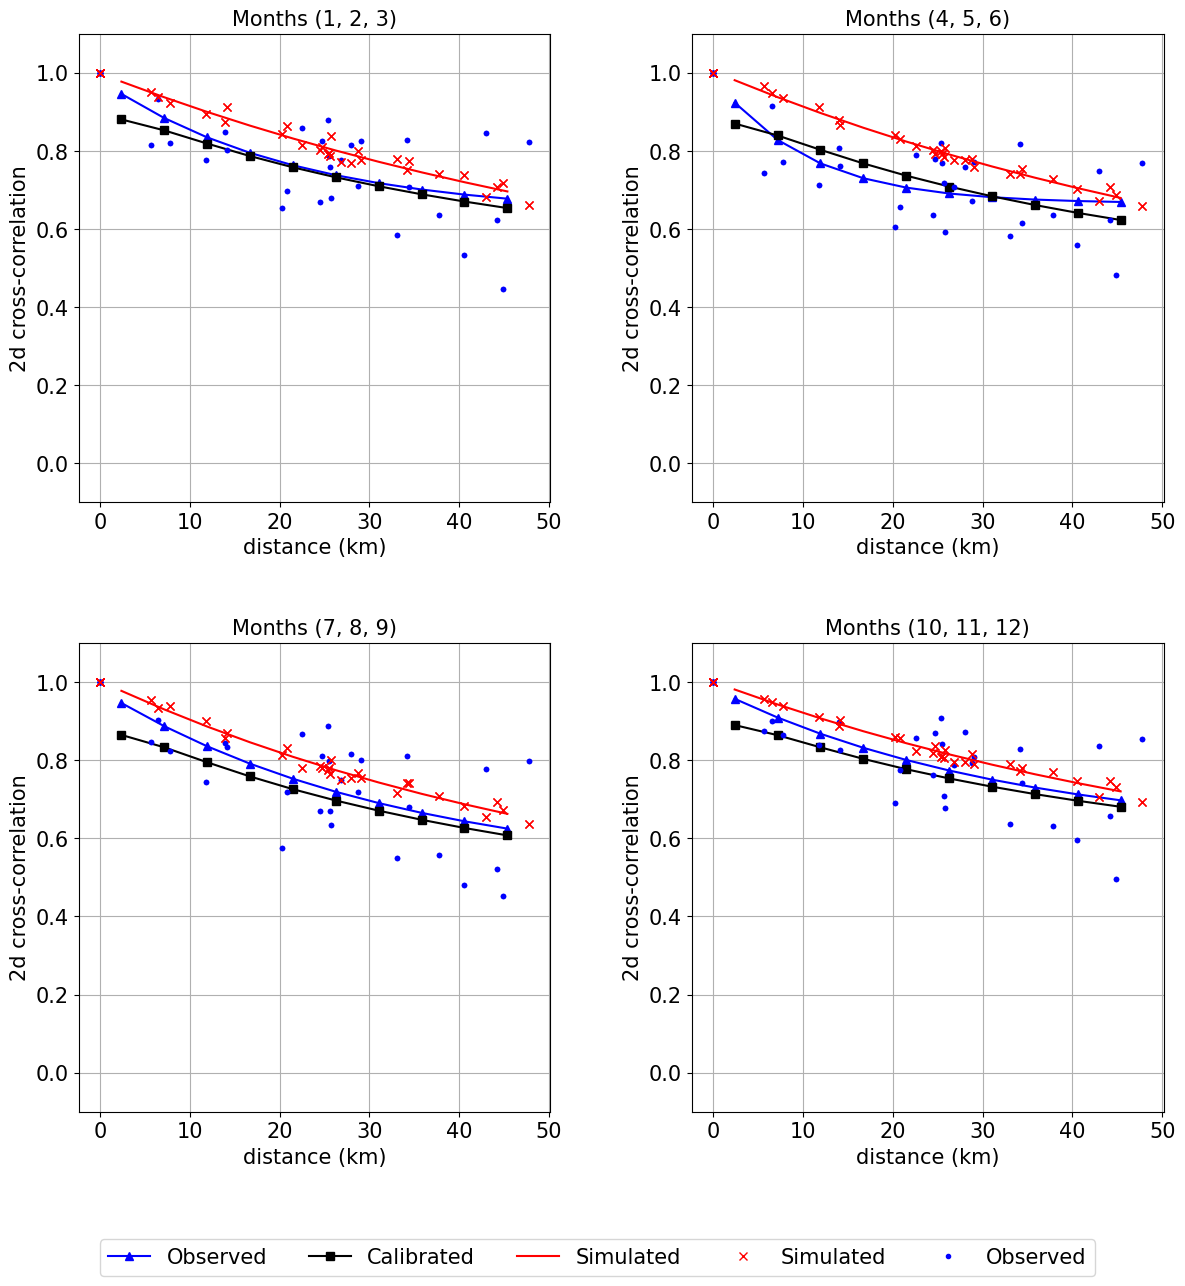

In [18]:
Analysis_results.correlation_fig()

### Validation

Another set of verification plots is generated where the value of different observed statistics (dashed line) is compared against the fitted statistics (blue squares), that is, the best values of the statistic that the optimal parameters were able to reproduce, and against the simulated statistics (red triangles), the values of the statistics that were obtained when simulating synthetic time series with the calibrated parameters.

The model correctly reproduces those parameters for which it is calibrated. Those parameters that do not participate in the calibration procedure may exhibit a more erratic behavior, thus the differences between the calibrated and simulated values of the statistics.

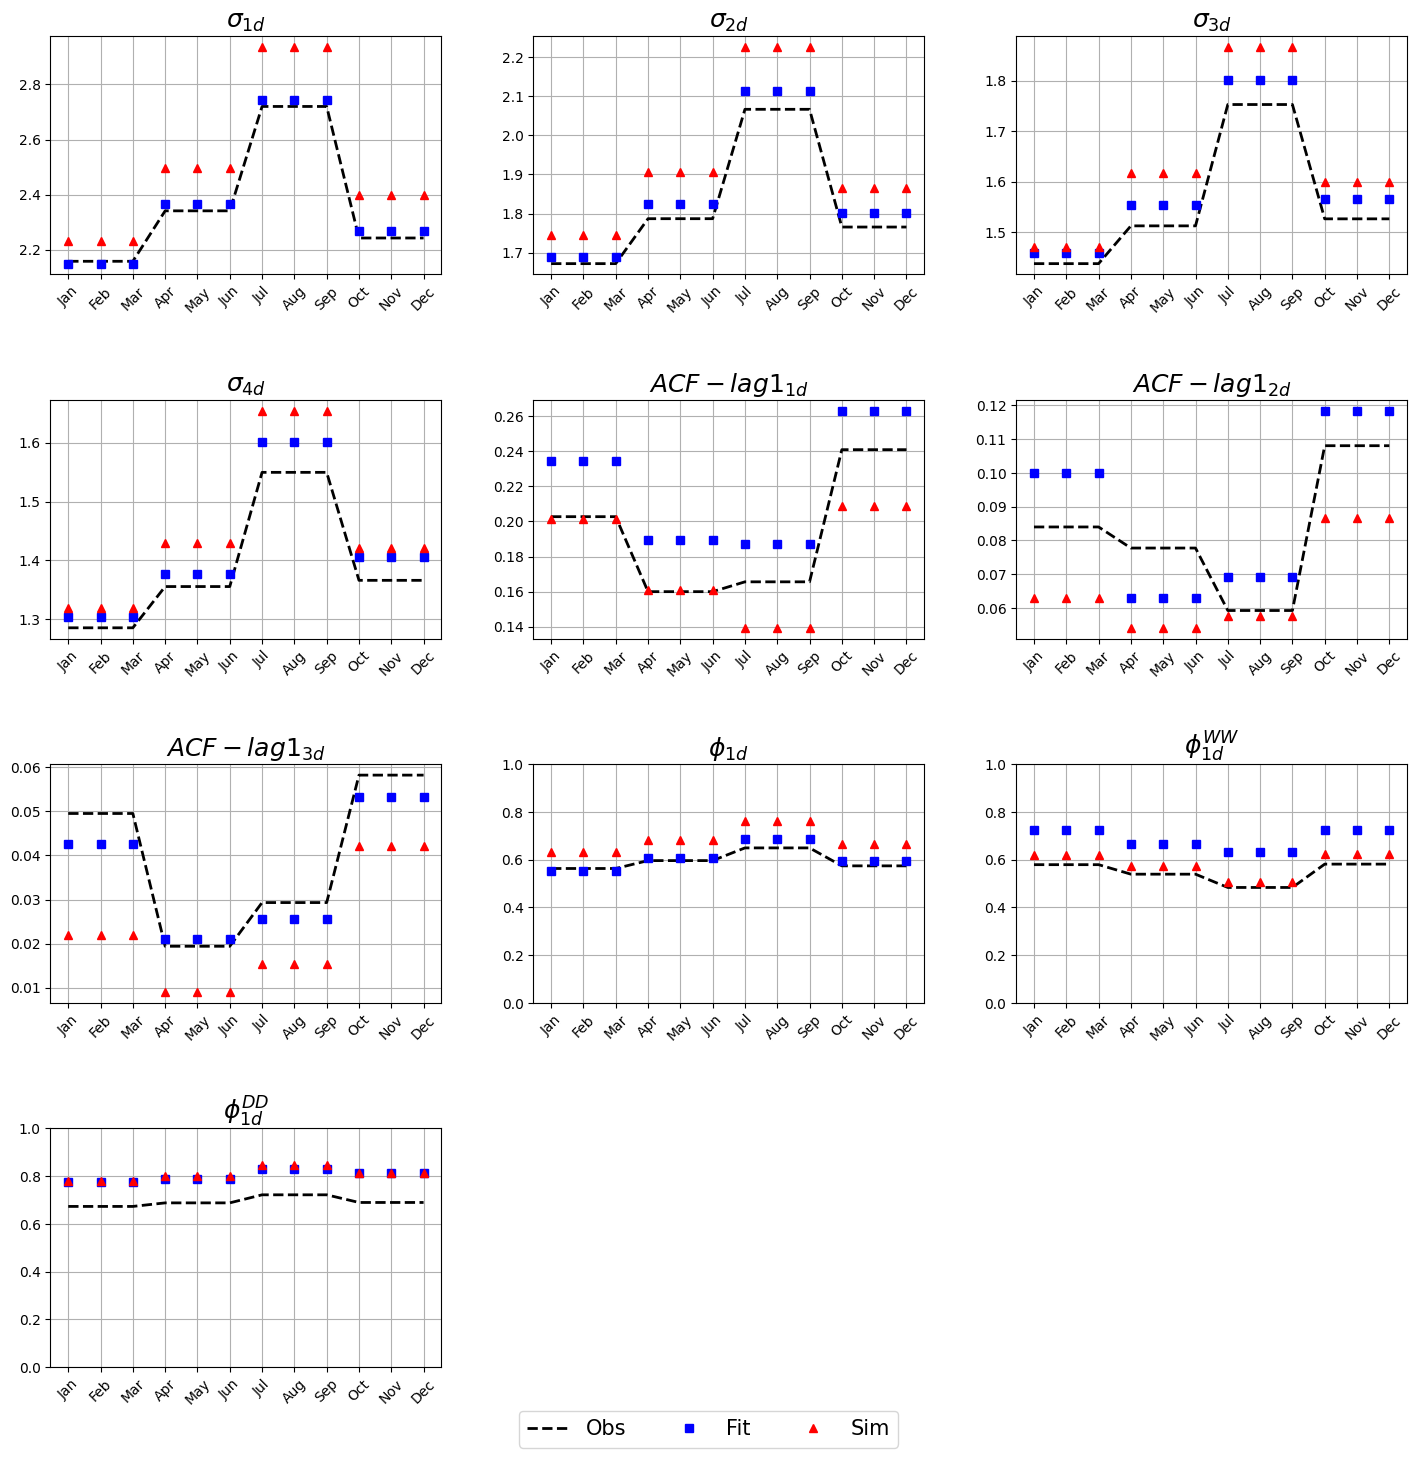

In [19]:
# Comparing the values of the statistcs (observed, fitted and simulated).
Analysis_results.compare_statistics_fig()

### Save Figures

To save the figures in png format we execute the following line

In [21]:
Analysis_results.save_figures('./POINT_SPATIAL_DAILY/Figures/')

## Example 2. Disaggregation of daily data to hourly data

Disaggregation process might take some minutes to dissagregate several decades of data. Here we select only 5 year as an example

In [22]:
# Period selected from the input (onserved) serie
year1 = 1985; year2 = 1990
x_series = Input_Series[(Input_Series.index.year >= year1) & (Input_Series.index.year < year2)]

In [23]:
# Defining hourly synthetic serie
y_series = SIM1.Hourly_Simulation.copy()

In [24]:
# Daily-to-hourly disaggregation
Analysis_results.disaggregate_rainfall(x_series, y_series)
hourly_disaggregation = Analysis_results.hourly_disaggregation

In [25]:
# Resampling hourly disaggregated serie to daily one. 
#The series is resampled through groupby to avoid possible problems when dates are greater than 2262 and less than 1677.
daily_disaggregation = pd.DataFrame(hourly_disaggregation.groupby([(hourly_disaggregation.index.year),
                                                                   (hourly_disaggregation.index.month),
                                                                   (hourly_disaggregation.index.day)]).sum().values,
                                    index=pd.period_range(start=hourly_disaggregation.index[0],end=hourly_disaggregation.index[-1],freq='D'),
                                    columns=hourly_disaggregation.columns)

# Session info

In [26]:
!conda list

# packages in environment at C:\Anaconda3\envs\NEOPRENE_2024:
#
# Name                    Version                   Build  Channel
anyio                     4.2.0              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py311ha68e1ae_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
bleach                    6.1.0              pyhd8ed1ab_0    conda-forge
brotli-python             1.1.0           py311h12c1d0e_1    conda-forge
bzip2                     1.0.8                hcfcfb64_5    conda